Here we will simulate a 2D thermoelastic problem where the domain consists of two rectangular slabs with different thermal properties.

The overall domain is $\Omega = [0,5] \times [-0.5,0.5]$ with $\Omega_{top} = [0,5] \times [0,0.5]$ and $\Omega_{bottom} = [0,5] \times [-0.5,0]$. All lengths are in $mm$. The thermal conductivity and expansion coefficient are

$k = k_{top} ∀ x \in \Omega_{top}$

$k = k_{bottom} ∀ x \in \Omega_{bottom}$


$\alpha = \alpha_{top} ∀ x \in \Omega_{top}$

$\alpha = \alpha_{bottom} ∀ x \in \Omega_{bottom}$

Part (a) of the assignment sets the same properties in both halves, and Part (b) sets them makes them different.

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
try:
    from firedrake import *
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/firedrake-install-development-real.sh" -O "/tmp/firedrake-install.sh" && bash "/tmp/firedrake-install.sh"
    from firedrake import *

--2025-03-17 20:11:33--  https://fem-on-colab.github.io/releases/firedrake-install-development-real.sh
Resolving fem-on-colab.github.io (fem-on-colab.github.io)... 185.199.110.153, 185.199.109.153, 185.199.108.153, ...
Connecting to fem-on-colab.github.io (fem-on-colab.github.io)|185.199.110.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4609 (4.5K) [application/x-sh]
Saving to: ‘/tmp/firedrake-install.sh’

/tmp/firedrake-inst 100%[===================>]   4.50K  --.-KB/s    in 0s      

2025-03-17 20:11:33 (44.7 MB/s) - ‘/tmp/firedrake-install.sh’ saved [4609/4609]

+ INSTALL_PREFIX=/usr/local
++ echo /usr/local
++ awk -F/ '{print NF-1}'
+ INSTALL_PREFIX_DEPTH=2
+ PROJECT_NAME=fem-on-colab
+ SHARE_PREFIX=/usr/local/share/fem-on-colab
+ FIREDRAKE_INSTALLED=/usr/local/share/fem-on-colab/firedrake.installed
+ [[ ! -f /usr/local/share/fem-on-colab/firedrake.installed ]]
+ PYBIND11_INSTALL_SCRIPT_PATH=https://github.com/fem-on-colab/fem-on-colab.github.io/raw/

In [3]:
!apt-get install gmsh
!pip install --upgrade gmsh

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  gmsh-doc libalglib3.18 libfltk-gl1.3 libfltk-images1.3 libfltk1.3 libfreeimage3 libglu1-mesa
  libgmsh4.8 libjxr0 libmetis5 libocct-data-exchange-7.5 libocct-foundation-7.5
  libocct-modeling-algorithms-7.5 libocct-modeling-data-7.5 libocct-ocaf-7.5
  libocct-visualization-7.5 libraw20 libtbb2 libvoro++1
The following NEW packages will be installed:
  gmsh gmsh-doc libalglib3.18 libfltk-gl1.3 libfltk-images1.3 libfltk1.3 libfreeimage3 libglu1-mesa
  libgmsh4.8 libjxr0 libmetis5 libocct-data-exchange-7.5 libocct-foundation-7.5
  libocct-modeling-algorithms-7.5 libocct-modeling-data-7.5 libocct-ocaf-7.5
  libocct-visualization-7.5 libraw20 libtbb2 libvoro++1
0 upgraded, 20 newly installed, 0 to remove and 29 not upgraded.
Need to get 30.9 MB of archives.
After this operation, 96.0 MB of additional disk space will be used.
Get:1 http://arc

In [4]:
import gmsh, ufl, os
from ufl import sqrt

In [5]:
# Give path to save the mesh file
meshPath = '/content/drive/MyDrive/'

def CP3mesh(Hmax, elementType, elementOrder):
  '''
  This function generates a 2D mesh based on mesh size Hmax, elementType and
  elementOrder.
  '''
  gmsh.initialize()
  gmsh.model.add('cp3mesh')
  meshObject = gmsh.model

  point1 = meshObject.geo.addPoint(0,-0.0005,0,Hmax,1)
  point2 = meshObject.geo.addPoint(.005,-.0005,0,Hmax,2)
  point3 = meshObject.geo.addPoint(.005,.0005,0,Hmax,3)
  point4 = meshObject.geo.addPoint(0,.0005,0,Hmax,4)

  line1 = meshObject.geo.addLine(point1, point2, 101)
  line2 = meshObject.geo.addLine(point2, point3, 102)
  line3 = meshObject.geo.addLine(point3, point4, 103)
  line4 = meshObject.geo.addLine(point4, point1, 104)

  boundary = meshObject.geo.addCurveLoop([line1, line2, line3, line4], 201)


  domain2D = meshObject.geo.addPlaneSurface([boundary], 301)

  meshObject.geo.synchronize()

  meshObject.addPhysicalGroup(2, [301], name='domain')

  meshObject.addPhysicalGroup(1, [line1], 1)
  meshObject.addPhysicalGroup(1, [line2], 2)
  meshObject.addPhysicalGroup(1, [line3], 3)
  meshObject.addPhysicalGroup(1, [line4], 4)


  meshObject.mesh.setOrder(elementOrder)

  if elementType == 2:
    # Generate quad mesh from triangles by recombination
    meshObject.mesh.setRecombine(2, domain2D)

  # Generate the mesh
  gmsh.model.mesh.generate(2)

  gmsh.write(meshPath + 'cp3ChipMeshFile.msh')

  gmsh.finalize()

  return

In [6]:
# Generate the mesh
#--------------Choose the element type and mesh size----------------------
elementOrder = 1 # Polynomial order in each element (integer)
elementType =  1 # 1 - Triangle; 2 - Quad
HMax = 0.5e-3 # 0.5,0.25,0.125,0.0625,0.03125
# generate mesh
CP3mesh(HMax, elementType, elementOrder)

In [7]:
from matplotlib import pyplot as plt
from firedrake.pyplot import tripcolor, tricontour, trisurf, triplot, tricontourf
import warnings
# Filter out the specific FutureWarning about interpolate
warnings.filterwarnings("ignore", message="The use of `interpolate` to perform the numerical interpolation is deprecated.")
%matplotlib inline
plt.rcParams.update({"text.usetex": False, "mathtext.fontset": "stix", "legend.fontsize": 12,
        "axes.labelsize": 15, "xtick.labelsize": 12, "ytick.labelsize": 12})

In [8]:
from google.colab import output
output.enable_custom_widget_manager()

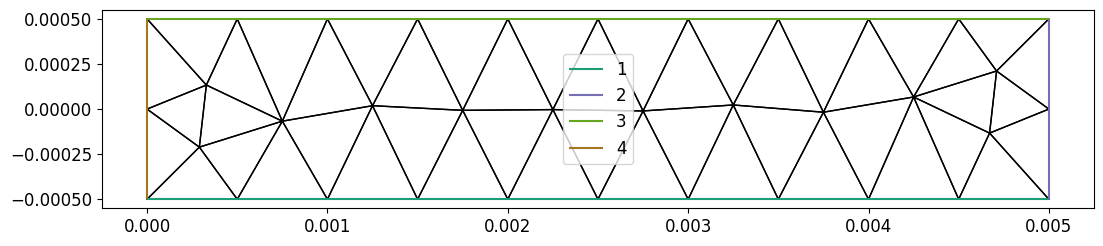

In [9]:
# get the mesh and store it
mesh = Mesh(meshPath + 'cp3ChipMeshFile.msh')
# create a figure to lot the mesh
fig, axes = plt.subplots(figsize=[12.8,5])
triplot(mesh, axes=axes)
axes.legend()
axes.set_aspect('equal')

First we need to solve the temperature field and then displacement field. Refer to this example for help in setting thermoelasticity problem ([example](https://comet-fenics.readthedocs.io/en/latest/demo/thermoelasticity/thermoelasticity.html)). Remember this example is for a single material property.

In [10]:
# Choose function space for temperature
if elementType == 1:
  VT = FunctionSpace(mesh, "P", elementOrder)
elif elementType == 2:
  VT = FunctionSpace(mesh, "Q", elementOrder)

In [11]:
# Test and trial function for temperature
T_test = TestFunction(VT)
T_trial = TrialFunction(VT)

For defining the material property at different locations of the domain use the firedrake [interpolate](https://www.firedrakeproject.org/interpolation.html) function with [conditional operator](https://fenics.readthedocs.io/projects/ufl/en/latest/manual/form_language.html). Using the conditional operator we can assign thermal properties based on location of a point (analogous to C++ conditional statement).

In [12]:
# Material properties
#--------------Complete the following lines of code----------------------
x = SpatialCoordinate(mesh)
# k_val = conditional((x[1] > 0), 10.0, 10.0)
# alpha_val = conditional((x[1] > 0), 95e-6, 95e-6)
# lamda_val = conditional((x[1] > 0), 12e+9, 12e+9)
# mu_val = conditional((x[1] > 0), 1e+9, 1e+9)

k_val = conditional((x[1] > 0), 148.0, 10.0)
alpha_val = conditional((x[1] > 0), 2.6e-6, 95e-6)
lamda_val = conditional((x[1] > 0), 256e+9, 12e+9)
mu_val = conditional((x[1] > 0), 64e+9, 1e+9)

In [13]:
k = Function(VT)
k.interpolate(k_val)
alpha = Function(VT)
alpha.interpolate(alpha_val)
lamda = Function(VT);
lamda.interpolate(lamda_val)
mu = Function(VT)
mu.interpolate(mu_val)

Coefficient(WithGeometry(FunctionSpace(<firedrake.mesh.MeshTopology object at 0x7a361383c290>, FiniteElement('Lagrange', triangle, 1), name=None), Mesh(VectorElement(FiniteElement('Lagrange', triangle, 1), dim=2), 0)), 21)

Explain how to set constants in Firedrake and Bcs function

In [14]:
# Boundary parameters for temperature
#--------------Complete the following lines of code----------------------
T_sub = 293.0
heat_flux = 50e3 + 20e6 * x[0]

In [15]:
#--------------Complete the following lines of code----------------------
# Variational equation for temperature
aT = k_val * dot(grad(T_trial), grad(T_test)) * dx
LT = heat_flux * T_test * ds(3) + Constant(0) * T_test * ds(2) + Constant(0) * T_test * ds(4)

In [16]:
#--------------Complete the following lines of code----------------------
# Dirichilet boundary condition at y = -0.5 mm
bcT = DirichletBC(VT, T_sub, 1)

In [17]:
# Create a function to store the solution
T_soln = Function(VT)

In [18]:
# Solve for temperature
solve(aT == LT, T_soln, bcs = bcT, solver_parameters={'ksp_type': 'gmres'})

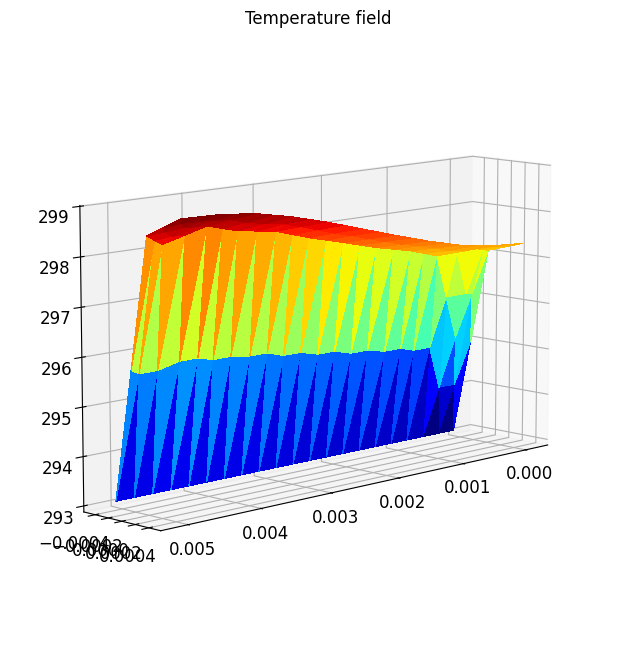

In [19]:
# Plot the solution
ax = plt.figure(figsize=[8,8]).add_subplot(projection='3d')
ax.view_init(elev=10, azim=45)
trisurf(T_soln, axes=ax, cmap='jet')
ax.set_title('Temperature field'),
ax.set_aspect('equalxy')

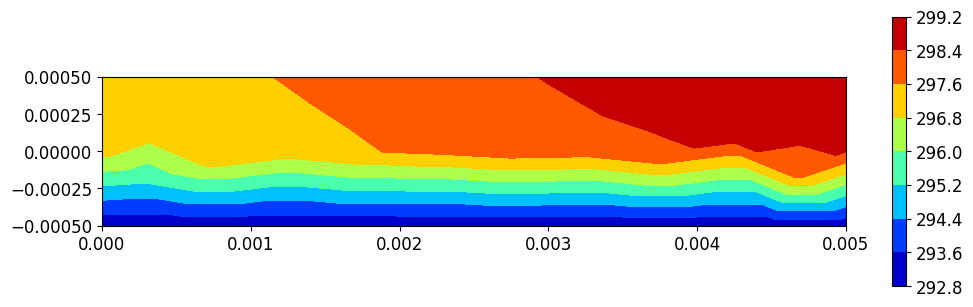

In [20]:
fig, axes = plt.subplots(figsize=[12,3.5])
contours = tricontourf(T_soln, axes=axes, cmap='jet')
fig.colorbar(contours)
axes.set_aspect('equal')

Create functions for stress and strain similar to the thermoelasiticy example.

In [ ]:
# Identity matrix
Id = Identity(mesh.geometric_dimension())
#--------------Complete the following lines of code----------------------
# strain tensor function
def epsilon(u, Temp, alpha):
  """
  Calculates the strain
  Args:
    u: displacement
    Temp: Temperature
    alpha: expansion coefficient
  Returns:
    epsilon: strain
  """
  return 0.5 * (grad(u) + grad(u).T) - alpha * Id * (Temp - T_sub)

In [ ]:
#--------------Complete the following lines of code----------------------
# stress tensor
def sigma(u, Temp, alpha):
  """
  Calculates the stress
  Args:
    u: displacement
    Temp: Temperature
    alpha: expansion coefficient
  Returns:
    sigma: stress
  """
  return lamda * tr(epsilon(u, Temp, alpha)) * Id + 2 * mu * epsilon(u, Temp, alpha)

In [ ]:
#--------------Complete the following lines of code----------------------
# von Misses stress function
def von_mises_stress(u, Temp, alpha):
  """
  Calculates the von Mises stress
  Args:
    u: displacement
    Temp: Temperature
    alpha: expansion coefficient
  Returns:
    von_mises: von Mises stress
  """
  s = sigma(u, Temp, alpha)
  dev_s = s - (1.0/3.0) * tr(s) * Id  # deviatoric stress
  return sqrt(3.0/2.0 * inner(dev_s, dev_s))

In [ ]:
# Vector function space for displacement
if elementType == 1:
  V = VectorFunctionSpace(mesh, "P", elementOrder)
elif elementType == 2:
  V = VectorFunctionSpace(mesh, "Q", elementOrder)

In [ ]:
# trial and test functions
u = TrialFunction(V)
v = TestFunction(V)

In [ ]:
#--------------Complete the following lines of code----------------------
# Variational equation for elasticity
a = lhs(inner(sigma(u, T_soln, alpha), grad(v)) * dx)
L = rhs(inner(sigma(u, T_soln, alpha), grad(v)) * dx) + inner(Constant((0.0, 0.0)), v) * (ds(1) + ds(2) + ds(3))

In [ ]:
#--------------Complete the following lines of code----------------------
# Dirichlet BC for displacement
bcu = DirichletBC(V, Constant((0.0, 0.0)), 4)

In [ ]:
# create a function in the function space for displacements
u_soln = Function(V)

In [ ]:
# solve for displacement
solve(a==L, u_soln, bcs = bcu)

In [ ]:
# interpolate the solutions into the FE spaces
# Temperatures
T_soln_interp = interpolate(T_soln, VT)
# displacements
u_soln_interp = interpolate(u_soln, V)

########### Gradients ########
# define the spaces to interpolate gradients
if elementType == 1:
  # gradients of scalar fields are vectors
  VT_grad = VectorFunctionSpace(mesh, "P", elementOrder)
  # gradients of vector fields are tensors
  V_grad = TensorFunctionSpace(mesh, "P", elementOrder)
elif elementType == 2:
  # gradients of scalar fields are vectors
  VT_grad = VectorFunctionSpace(mesh, "Q", elementOrder)
  # gradients of vector fields are tensors
  V_grad = TensorFunctionSpace(mesh, "Q", elementOrder)

gradT_soln = interpolate(grad(T_soln), VT_grad)
gradu_soln = interpolate(grad(u_soln), V_grad)

In [ ]:
from ufl import sqrt, grad  # Importing grad directly

def mesh_sampling(num_points_x, num_points_y, mesh, field):
    """
    Samples a given field (Function or Gradient) on a mesh grid.

    Args:
        num_points_x (int): Number of sampling points in the x-direction.
        num_points_y (int): Number of sampling points in the y-direction.
        mesh (firedrake.Mesh): The mesh to sample on.
        field (firedrake.Function or ufl.grad.Gradient): The field to sample.

    Returns:
        numpy.ndarray: An array containing the sampled values and their coordinates.
                        Shape: (num_points_x * num_points_y, 3) for scalar/vector fields,
                               (num_points_x * num_points_y, 5) for tensor fields.
    """
    # Define the bounds of your mesh grid
    x_min, x_max = mesh.coordinates.dat.data_ro[:, 0].min(), mesh.coordinates.dat.data_ro[:, 0].max()
    y_min, y_max = mesh.coordinates.dat.data_ro[:, 1].min(), mesh.coordinates.dat.data_ro[:, 1].max()

    # Create a mesh grid
    x_coords = np.linspace(x_min, x_max, num_points_x)
    y_coords = np.linspace(y_min, y_max, num_points_y)
    X, Y = np.meshgrid(x_coords, y_coords)

    # Sample the solution at the mesh grid points
    # Initialize sampled_values based on field shape
    if isinstance(field, ufl.Coefficient) and field.ufl_shape:
        if len(field.ufl_shape) == 1 and field.ufl_shape[0] > 1: # vector field
            sampled_values = np.zeros((num_points_y, num_points_x, field.ufl_shape[0]))
        elif len(field.ufl_shape) == 2: # tensor field
            sampled_values = np.zeros((num_points_y, num_points_x, field.ufl_shape[0], field.ufl_shape[1]))
        else: # scalar field
            sampled_values = np.zeros_like(X)
    else: # Function
        sampled_values = np.zeros_like(X)

    # Check if field is a gradient or a Function
    if isinstance(field, ufl.Coefficient) and field.ufl_shape:
        for i in range(num_points_x):
            for j in range(num_points_y):
                sampled_values[j, i] = field.at([X[j, i], Y[j, i]])
    else:
        for i in range(num_points_x):
            for j in range(num_points_y):
                sampled_values[j, i] = field.at([X[j, i], Y[j, i]])

    # --- Handling different data structures ----
    if len(sampled_values.shape) == 2:  # Scalar field
        # Create an array to store coordinates and sampled values
        coordinates_and_values = np.zeros((num_points_x * num_points_y, 3))

        # Populate the array
        index = 0
        for i in range(num_points_x):
            for j in range(num_points_y):
                coordinates_and_values[index, 0] = X[j, i]
                coordinates_and_values[index, 1] = Y[j, i]
                coordinates_and_values[index, 2] = sampled_values[j, i]
                index += 1

    elif len(sampled_values.shape) == 3 and sampled_values.shape[2] == 2:  # Vector field with 2 components (x, y)
        # Create an array to store coordinates and sampled values
        coordinates_and_values = np.zeros((num_points_x * num_points_y, 4))  # 4 columns: x, y, u_x, u_y

        # Populate the array
        index = 0
        for i in range(num_points_x):
            for j in range(num_points_y):
                coordinates_and_values[index, 0] = X[j, i]
                coordinates_and_values[index, 1] = Y[j, i]
                coordinates_and_values[index, 2:] = sampled_values[j, i]  # Store u_x, u_y
                index += 1

    elif len(sampled_values.shape) == 3:  # Tensor field (like a gradient) with more than 2 components
        # Create an array to store coordinates and sampled values
        num_components = sampled_values.shape[-1]
        coordinates_and_values = np.zeros((num_points_x * num_points_y, 3 + num_components))
        # Populate the array
        index = 0
        for i in range(num_points_x):
            for j in range(num_points_y):
                coordinates_and_values[index, 0] = X[j, i]
                coordinates_and_values[index, 1] = Y[j, i]
                coordinates_and_values[index, 2:] = sampled_values[j, i].flatten()  # Flatten the tensor components
                index += 1
    elif len(sampled_values.shape) == 4:  # Tensor field (like a gradient)
        # Create an array to store coordinates and sampled values
        coordinates_and_values = np.zeros((num_points_x * num_points_y, 2 + sampled_values.shape[2] * sampled_values.shape[3]))  # 2 for coordinates, 4 for tensor components

        # Populate the array
        index = 0
        for i in range(num_points_x):
            for j in range(num_points_y):
                coordinates_and_values[index, 0] = X[j, i]
                coordinates_and_values[index, 1] = Y[j, i]
                # Reshape sampled_values[j, i] to (4,) and assign to coordinates_and_values
                coordinates_and_values[index, 2:] = sampled_values[j, i].flatten() # Reshape to (4,)
                index += 1
    # all done
    return coordinates_and_values

In [ ]:
# Sample the data
# 50 below is the number of sampling points
sampled_T = mesh_sampling(50, 50, mesh, T_soln)
sampled_u = mesh_sampling(50, 50, mesh, u_soln)
sampled_gradT = mesh_sampling(50, 50, mesh, gradT_soln)
sampled_gradu = mesh_sampling(50, 50, mesh, gradu_soln)

# Save the data to .npz files
np.savez('sampled_T.npz', sampled_T=sampled_T)
# np.savez('sampled_u.npz', sampled_u=sampled_u)
np.savez(f'sampled_u_{elementOrder}_{elementType}_{HMax}.npz', sampled_u=sampled_u)
np.savez('sampled_gradT.npz', sampled_gradT=sampled_gradT)
# np.savez('sampled_gradu.npz', sampled_gradu=sampled_gradu)
np.savez(f'sampled_gradu_{elementOrder}_{elementType}_{HMax}.npz', sampled_gradu=sampled_gradu)

In [ ]:
######### Example of use #############
# Load the sampled temperature data
data = np.load('sampled_T.npz')
sampled_T = data['sampled_T']

# Extract x, y, and temperature values
x = sampled_T[:, 0]
y = sampled_T[:, 1]
T = sampled_T[:, 2]

# Reshape the data for contour plotting
# Assuming your sampling grid is regular
num_points_x = 50  # Replace with your actual number of points in x
num_points_y = 50  # Replace with your actual number of points in y
X = x.reshape(num_points_y, num_points_x)
Y = y.reshape(num_points_y, num_points_x)
T_grid = T.reshape(num_points_y, num_points_x)

# Create the contour plot
plt.figure(figsize=(8, 6))
contour = plt.contourf(X, Y, T_grid, cmap='jet')  # Use contourf for filled contours
plt.colorbar(contour, label='Temperature')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Contour Plot of Sampled Temperature')
plt.axis('equal')
plt.show()

In [ ]:
################## EXAMPLE TO LOAD GRADIENTS ################
data = np.load('sampled_gradT.npz')  # Assuming you saved it as 'sampled_gradT.npz'
sampled_gradT = data['sampled_gradT']

# Extract x, y, and gradient components
x = sampled_gradT[:, 0]
y = sampled_gradT[:, 1]
gradT_x = sampled_gradT[:, 2]  # x-component of the gradient
gradT_y = sampled_gradT[:, 3]  # x-component of the gradient

# Reshape the data for contour plotting
num_points_x = 50  # Replace with your actual number of points in x
num_points_y = 50  # Replace with your actual number of points in y
X = x.reshape(num_points_y, num_points_x)
Y = y.reshape(num_points_y, num_points_x)
gradT_x_grid = gradT_x.reshape(num_points_y, num_points_x)
gradT_y_grid = gradT_y.reshape(num_points_y, num_points_x)

# Create the contour plot
plt.figure(figsize=(8, 6))
contour = plt.contourf(X, Y, gradT_x_grid, cmap='jet')
plt.colorbar(contour, label='dT/dx')  # Label the colorbar
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Contour Plot of x-component of Temperature Gradient')
plt.axis('equal')
plt.show()

# Create the contour plot
plt.figure(figsize=(8, 6))
contour = plt.contourf(X, Y, gradT_y_grid, cmap='jet')
plt.colorbar(contour, label='dT/dy')  # Label the colorbar
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Contour Plot of y-component of Temperature Gradient')
plt.axis('equal')
plt.show()

In [ ]:
# plot the x-component of the displacement field
fig, axes = plt.subplots(figsize=[12,3.5])
u_sol_x = u_soln.sub(0)
contours = tricontourf(u_sol_x, axes=axes, cmap='jet')
fig.colorbar(contours)
axes.set_title('x-direction displacement field')
axes.set_aspect('equal')

In [ ]:
# plot the y-component of the displacement field
fig, axes = plt.subplots(figsize=[12,3.5])
u_sol_y = u_soln.sub(1)
contours = tricontourf(u_sol_y, axes=axes, cmap='jet')
ax.set_title('y-direction displacement field')
fig.colorbar(contours)
axes.set_aspect('equal')

In [ ]:
# plot von-Misess stresses
von_mises = von_mises_stress(u_soln, T_soln, alpha)
# projec the space in a P0 discontinous space
V_stress = FunctionSpace(mesh, "DG", 0)
# Ensure von_mises is projected onto the same function space as von_mises_function
von_mises_projected = project(von_mises, V_stress)
von_mises_function = Function(V_stress)
von_mises_function.interpolate(von_mises_projected)
# plot von Mises stresses
fig, axes = plt.subplots(figsize=[12,3.5])
contours = tricontourf(von_mises_function, axes=axes, cmap='jet')
fig.colorbar(contours)
axes.set_aspect('equal')

In [ ]:
# Deformed mesh
# ~ store the undeformed mesh for comparing
mesh_init = Mesh(meshPath + 'cp3ChipMeshFile.msh')
# ~ store a copy of the undeformed mesh to not override it
deformed_mesh = Mesh(meshPath + 'cp3ChipMeshFile.msh')

# ~ create a FE space to project displacements and use them to deform the mesh
if elementType == 1:
  V_deformed = VectorFunctionSpace(deformed_mesh, "CG", elementOrder)
elif elementType == 2:
  print("entre")
  V_deformed = VectorFunctionSpace(deformed_mesh, "Lagrange", elementOrder)

# ~ define the magnification factor
amp_mag = 100

# Get coordinates of the nodes of the deformed mesh
coordinates = deformed_mesh.coordinates.dat.data_ro

# Evaluate u_soln at the coordinates of the deformed mesh
u_soln_values = u_soln.at(coordinates)

# Convert u_soln_values to a NumPy array
import numpy as np
u_soln_values = np.array(u_soln_values)

# Calculate the displaced coordinates (magnified by amp_mag)
displaced_coordinates = coordinates + u_soln_values * amp_mag

# Update the mesh coordinates to their deformed positions
deformed_mesh.coordinates.dat.data[:] = displaced_coordinates

In [ ]:
fig, axes = plt.subplots(figsize=[12,5])
triplot(mesh_init, axes=axes, interior_kw={"edgecolors":"blue"})
triplot(deformed_mesh, axes=axes, interior_kw={"edgecolors":"red"})
axes.set_aspect('equal')

## Analyzing results
L2 norm and H1 seminorm

In [ ]:
Hmaxs = [0.5e-3,0.25e-3,0.125e-3,0.0625e-3,0.03125e-3]

for elementOrder in [1,2]:
  for elementType in [1,2]:
    for HMax in Hmaxs:
      # generate mesh
      CP3mesh(HMax, elementType, elementOrder)
      # get the mesh and store it
      mesh = Mesh(meshPath + 'cp3ChipMeshFile.msh')
      # Choose function space for temperature
      if elementType == 1:
        VT = FunctionSpace(mesh, "P", elementOrder)
      elif elementType == 2:
        VT = FunctionSpace(mesh, "Q", elementOrder)
      # Test and trial function for temperature
      T_test = TestFunction(VT)
      T_trial = TrialFunction(VT)
      # Material properties
      #--------------Complete the following lines of code----------------------
      x = SpatialCoordinate(mesh)
      k_val = conditional((x[1] > 0), 10.0, 10.0)
      alpha_val = conditional((x[1] > 0), 95e-6, 95e-6)
      lamda_val = conditional((x[1] > 0), 12e+9, 12e+9)
      mu_val = conditional((x[1] > 0), 1e+9, 1e+9)

      # k_val = conditional((x[1] > 0), 148.0, 10.0)
      # alpha_val = conditional((x[1] > 0), 2.6e-6, 95e-6)
      # lamda_val = conditional((x[1] > 0), 256e+9, 12e+9)
      # mu_val = conditional((x[1] > 0), 64e+9, 1e+9)
      k = Function(VT)
      k.interpolate(k_val)
      alpha = Function(VT)
      alpha.interpolate(alpha_val)
      lamda = Function(VT);
      lamda.interpolate(lamda_val)
      mu = Function(VT)
      mu.interpolate(mu_val)
      # Boundary parameters for temperature
      #--------------Complete the following lines of code----------------------
      T_sub = 293.0
      heat_flux = 50e3 + 20e6 * x[0]
      #--------------Complete the following lines of code----------------------
      # Variational equation for temperature
      aT = k_val * dot(grad(T_trial), grad(T_test)) * dx
      LT = heat_flux * T_test * ds(3) + Constant(0) * T_test * ds(2) + Constant(0) * T_test * ds(4)
      #--------------Complete the following lines of code----------------------
      # Dirichilet boundary condition at y = -0.5 mm
      bcT = DirichletBC(VT, T_sub, 1)
      # Create a function to store the solution
      T_soln = Function(VT)
      # Solve for temperature
      solve(aT == LT, T_soln, bcs = bcT, solver_parameters={'ksp_type': 'gmres'})
      # Identity matrix
      Id = Identity(mesh.geometric_dimension())
      #--------------Complete the following lines of code----------------------
      # strain tensor function
      def epsilon(u, Temp, alpha):
        """
        Calculates the strain
        Args:
          u: displacement
          Temp: Temperature
          alpha: expansion coefficient
        Returns:
          epsilon: strain
        """
        return 0.5 * (grad(u) + grad(u).T) - alpha * Id * (Temp - T_sub)
      #--------------Complete the following lines of code----------------------
      # stress tensor
      def sigma(u, Temp, alpha):
        """
        Calculates the stress
        Args:
          u: displacement
          Temp: Temperature
          alpha: expansion coefficient
        Returns:
          sigma: stress
        """
        return lamda * tr(epsilon(u, Temp, alpha)) * Id + 2 * mu * epsilon(u, Temp, alpha)
      #--------------Complete the following lines of code----------------------
      # von Misses stress function
      def von_mises_stress(u, Temp, alpha):
        """
        Calculates the von Mises stress
        Args:
          u: displacement
          Temp: Temperature
          alpha: expansion coefficient
        Returns:
          von_mises: von Mises stress
        """
        s = sigma(u, Temp, alpha)
        dev_s = s - (1.0/3.0) * tr(s) * Id  # deviatoric stress
        return sqrt(3.0/2.0 * inner(dev_s, dev_s))
      # Vector function space for displacement
      if elementType == 1:
        V = VectorFunctionSpace(mesh, "P", elementOrder)
      elif elementType == 2:
        V = VectorFunctionSpace(mesh, "Q", elementOrder)
      # trial and test functions
      u = TrialFunction(V)
      v = TestFunction(V)
      #--------------Complete the following lines of code----------------------
      # Variational equation for elasticity
      a = lhs(inner(sigma(u, T_soln, alpha), grad(v)) * dx)
      L = rhs(inner(sigma(u, T_soln, alpha), grad(v)) * dx) + inner(Constant((0.0, 0.0)), v) * (ds(1) + ds(2) + ds(3))
      #--------------Complete the following lines of code----------------------
      # Dirichlet BC for displacement
      bcu = DirichletBC(V, Constant((0.0, 0.0)), 4)
      # create a function in the function space for displacements
      u_soln = Function(V)
      # solve for displacement
      solve(a==L, u_soln, bcs = bcu)
      # interpolate the solutions into the FE spaces
      # Temperatures
      T_soln_interp = interpolate(T_soln, VT)
      # displacements
      u_soln_interp = interpolate(u_soln, V)

      ########### Gradients ########
      # define the spaces to interpolate gradients
      if elementType == 1:
        # gradients of scalar fields are vectors
        VT_grad = VectorFunctionSpace(mesh, "P", elementOrder)
        # gradients of vector fields are tensors
        V_grad = TensorFunctionSpace(mesh, "P", elementOrder)
      elif elementType == 2:
        # gradients of scalar fields are vectors
        VT_grad = VectorFunctionSpace(mesh, "Q", elementOrder)
        # gradients of vector fields are tensors
        V_grad = TensorFunctionSpace(mesh, "Q", elementOrder)

      gradT_soln = interpolate(grad(T_soln), VT_grad)
      gradu_soln = interpolate(grad(u_soln), V_grad)
      from ufl import sqrt, grad  # Importing grad directly

      def mesh_sampling(num_points_x, num_points_y, mesh, field):
          """
          Samples a given field (Function or Gradient) on a mesh grid.

          Args:
              num_points_x (int): Number of sampling points in the x-direction.
              num_points_y (int): Number of sampling points in the y-direction.
              mesh (firedrake.Mesh): The mesh to sample on.
              field (firedrake.Function or ufl.grad.Gradient): The field to sample.

          Returns:
              numpy.ndarray: An array containing the sampled values and their coordinates.
                              Shape: (num_points_x * num_points_y, 3) for scalar/vector fields,
                                    (num_points_x * num_points_y, 5) for tensor fields.
          """
          # Define the bounds of your mesh grid
          x_min, x_max = mesh.coordinates.dat.data_ro[:, 0].min(), mesh.coordinates.dat.data_ro[:, 0].max()
          y_min, y_max = mesh.coordinates.dat.data_ro[:, 1].min(), mesh.coordinates.dat.data_ro[:, 1].max()

          # Create a mesh grid
          x_coords = np.linspace(x_min, x_max, num_points_x)
          y_coords = np.linspace(y_min, y_max, num_points_y)
          X, Y = np.meshgrid(x_coords, y_coords)

          # Sample the solution at the mesh grid points
          # Initialize sampled_values based on field shape
          if isinstance(field, ufl.Coefficient) and field.ufl_shape:
              if len(field.ufl_shape) == 1 and field.ufl_shape[0] > 1: # vector field
                  sampled_values = np.zeros((num_points_y, num_points_x, field.ufl_shape[0]))
              elif len(field.ufl_shape) == 2: # tensor field
                  sampled_values = np.zeros((num_points_y, num_points_x, field.ufl_shape[0], field.ufl_shape[1]))
              else: # scalar field
                  sampled_values = np.zeros_like(X)
          else: # Function
              sampled_values = np.zeros_like(X)

          # Check if field is a gradient or a Function
          if isinstance(field, ufl.Coefficient) and field.ufl_shape:
              for i in range(num_points_x):
                  for j in range(num_points_y):
                      sampled_values[j, i] = field.at([X[j, i], Y[j, i]])
          else:
              for i in range(num_points_x):
                  for j in range(num_points_y):
                      sampled_values[j, i] = field.at([X[j, i], Y[j, i]])

          # --- Handling different data structures ----
          if len(sampled_values.shape) == 2:  # Scalar field
              # Create an array to store coordinates and sampled values
              coordinates_and_values = np.zeros((num_points_x * num_points_y, 3))

              # Populate the array
              index = 0
              for i in range(num_points_x):
                  for j in range(num_points_y):
                      coordinates_and_values[index, 0] = X[j, i]
                      coordinates_and_values[index, 1] = Y[j, i]
                      coordinates_and_values[index, 2] = sampled_values[j, i]
                      index += 1

          elif len(sampled_values.shape) == 3 and sampled_values.shape[2] == 2:  # Vector field with 2 components (x, y)
              # Create an array to store coordinates and sampled values
              coordinates_and_values = np.zeros((num_points_x * num_points_y, 4))  # 4 columns: x, y, u_x, u_y

              # Populate the array
              index = 0
              for i in range(num_points_x):
                  for j in range(num_points_y):
                      coordinates_and_values[index, 0] = X[j, i]
                      coordinates_and_values[index, 1] = Y[j, i]
                      coordinates_and_values[index, 2:] = sampled_values[j, i]  # Store u_x, u_y
                      index += 1

          elif len(sampled_values.shape) == 3:  # Tensor field (like a gradient) with more than 2 components
              # Create an array to store coordinates and sampled values
              num_components = sampled_values.shape[-1]
              coordinates_and_values = np.zeros((num_points_x * num_points_y, 3 + num_components))
              # Populate the array
              index = 0
              for i in range(num_points_x):
                  for j in range(num_points_y):
                      coordinates_and_values[index, 0] = X[j, i]
                      coordinates_and_values[index, 1] = Y[j, i]
                      coordinates_and_values[index, 2:] = sampled_values[j, i].flatten()  # Flatten the tensor components
                      index += 1
          elif len(sampled_values.shape) == 4:  # Tensor field (like a gradient)
              # Create an array to store coordinates and sampled values
              coordinates_and_values = np.zeros((num_points_x * num_points_y, 2 + sampled_values.shape[2] * sampled_values.shape[3]))  # 2 for coordinates, 4 for tensor components

              # Populate the array
              index = 0
              for i in range(num_points_x):
                  for j in range(num_points_y):
                      coordinates_and_values[index, 0] = X[j, i]
                      coordinates_and_values[index, 1] = Y[j, i]
                      # Reshape sampled_values[j, i] to (4,) and assign to coordinates_and_values
                      coordinates_and_values[index, 2:] = sampled_values[j, i].flatten() # Reshape to (4,)
                      index += 1
          # all done
          return coordinates_and_values
      # Sample the data
      # 50 below is the number of sampling points
      sampled_T = mesh_sampling(50, 50, mesh, T_soln)
      sampled_u = mesh_sampling(50, 50, mesh, u_soln)
      sampled_gradT = mesh_sampling(50, 50, mesh, gradT_soln)
      sampled_gradu = mesh_sampling(50, 50, mesh, gradu_soln)

      # Save the data to .npz files
      np.savez('sampled_T.npz', sampled_T=sampled_T)
      # np.savez('sampled_u.npz', sampled_u=sampled_u)
      np.savez(f'sampled_u_{elementOrder}_{elementType}_{HMax}.npz', sampled_u=sampled_u)
      np.savez('sampled_gradT.npz', sampled_gradT=sampled_gradT)
      # np.savez('sampled_gradu.npz', sampled_gradu=sampled_gradu)
      np.savez(f'sampled_gradu_{elementOrder}_{elementType}_{HMax}.npz', sampled_gradu=sampled_gradu)

Convergence rate

In [ ]:
def L2_norm(x):
  return np.linalg.norm(x)

In [ ]:
def H1_seminorm(x, gradx):
  return np.sqrt(L2_norm(x) ** 2 + L2_norm(gradx) ** 2)

In [ ]:
import matplotlib.pyplot as plt
Hmaxs = [0.5e-3,0.25e-3,0.125e-3,0.0625e-3,0.03125e-3]

for elementOrder in [1,2]:
  for elementType in [1,2]:
    ref_u = np.load(f'sampled_u_{elementOrder}_{elementType}_{Hmaxs[-1]}.npz')['sampled_u']
    ref_gradu = np.load(f'sampled_gradu_{elementOrder}_{elementType}_{Hmaxs[-1]}.npz')['sampled_gradu']
    L2_norms, H1_norms = [], []
    for HMax in Hmaxs:
      u_data = np.load(f'sampled_u_{elementOrder}_{elementType}_{HMax}.npz')['sampled_u']
      gradu_data = np.load(f'sampled_gradu_{elementOrder}_{elementType}_{HMax}.npz')['sampled_gradu']
      L2_norms.append(L2_norm(u_data - ref_u))
      H1_norms.append(H1_seminorm(u_data - ref_u, gradu_data - ref_gradu))

    # Create log-log plots
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.loglog(Hmaxs[:-1], L2_norms[:-1], 'o-', label=f'Order {elementOrder}, Type {elementType}')

    # Fit linear line in log-log space for L2 norm
    log_hmaxs = np.log(Hmaxs[:-1])
    log_L2 = np.log(L2_norms[:-1])
    slope_L2, intercept_L2 = np.polyfit(log_hmaxs, log_L2, 1)
    fit_line_L2 = np.exp(intercept_L2) * np.array(Hmaxs[:-1])**slope_L2
    plt.loglog(Hmaxs[:-1], fit_line_L2, '--', label=f'Slope: {slope_L2:.2f}')

    plt.xlabel('Mesh size (h)')
    plt.ylabel('L2 Error')
    plt.title('L2 Error Convergence')
    plt.grid(True, which="both", ls="--")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.loglog(Hmaxs[:-1], H1_norms[:-1], 'o-', label=f'Order {elementOrder}, Type {elementType}')

    # Fit linear line in log-log space for H1 norm
    log_H1 = np.log(H1_norms[:-1])
    slope_H1, intercept_H1 = np.polyfit(log_hmaxs, log_H1, 1)
    fit_line_H1 = np.exp(intercept_H1) * np.array(Hmaxs[:-1])**slope_H1
    plt.loglog(Hmaxs[:-1], fit_line_H1, '--', label=f'Slope: {slope_H1:.2f}')

    plt.xlabel('Mesh size (h)')
    plt.ylabel('H1 Error')
    plt.title('H1 Error Convergence')
    plt.grid(True, which="both", ls="--")
    plt.legend()
    plt.tight_layout()
    plt.savefig(f'convergence_plot_order{elementOrder}_type{elementType}.png', dpi=300)

## Visualizing results
For visualizing the results, we can export the output from Firedrake as VTK files to be read by ParaView for visualization. Here is the link to exporting data from Firedrake as VTK file ([visualization](https://www.firedrakeproject.org/visualisation.html))

In [ ]:
from firedrake.output import VTKFile
# Save data as VTK files
temperature = VTKFile("temperature.pvd")
displacements= VTKFile("displacements.pvd")
temperature.write(T_soln)
displacements.write(u_soln)

Support for third party widgets will remain active for the duration of the session. To disable support:

In [ ]:
from google.colab import output
output.disable_custom_widget_manager()